In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
import os

In [2]:
# Parameter
img_width, img_height = 150, 150
batch_size = 16
epochs = 20
num_classes = 7 # jumlah kelas

# Direktori data
train_data_dir = 'D:\Seluruh File Skripsi Arya\dataset\Train'
validation_data_dir = 'D:\Seluruh File Skripsi Arya\dataset\Valid'



In [3]:
# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

# Generator untuk membaca gambar dari direktori dataset
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical' # Menggunakan categorical untuk klasifikasi multiklas
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical'
)


Found 748 images belonging to 7 classes.
Found 497 images belonging to 7 classes.


In [7]:
# Membangun model CNN
model = Sequential([

# mengambil ekstraksi fitur seperti warna RGB secara otomatis 
# melalui Conv2D atau lapisan Convolusi pertama
Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
MaxPooling2D(pool_size=(2, 2)),

# lapisan Convolusi ke dua
Conv2D(64, (3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),

# lapisan Convolusi ke tiga
Conv2D(128, (3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),

# lapisan Convolusi ke empat
Conv2D(256, (3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),

# # lapisan untuk meratakan hasil Convolusi menjadi 1 dimensi
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))

# # lapisan output
# model.add(Dense(1, activation='sigmoid'))

# Flatten lapisan untuk meratakan hasil konvolusi menjadi satu dimensi
Flatten(),
    
# Lapisan dense pertama
Dense(512, activation='relu'),
Dropout(0.5),
    
# Lapisan output
Dense(num_classes, activation='softmax')  # Menggunakan softmax untuk klasifikasi multiklas
])

# lapisan untuk mengkompilasi atau menjalankan model
# model.compile(loss='binary_crossentropy',
            #   optimizer='adam',
            #   metrics=['accuracy'])
model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
model.summary()

# Early stopping atau pemberhentian secara otomatis 
# jika model yang di train tidak kunjung mengalami peningkatan dalam accuracy-nya
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [8]:
# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)


Epoch 1/20
46/46 [==============================] - 100s 2s/step - loss: 1.8498 - accuracy: 0.2650 - val_loss: 1.7646 - val_accuracy: 0.2742
Epoch 2/20
46/46 [==============================] - 95s 2s/step - loss: 1.6331 - accuracy: 0.3675 - val_loss: 1.7494 - val_accuracy: 0.2500
Epoch 3/20
46/46 [==============================] - 92s 2s/step - loss: 1.5753 - accuracy: 0.3784 - val_loss: 1.7921 - val_accuracy: 0.3569
Epoch 4/20
46/46 [==============================] - 85s 2s/step - loss: 1.5038 - accuracy: 0.3893 - val_loss: 1.5212 - val_accuracy: 0.3488
Epoch 5/20
46/46 [==============================] - 83s 2s/step - loss: 1.4662 - accuracy: 0.4262 - val_loss: 1.5288 - val_accuracy: 0.4375
Epoch 6/20
46/46 [==============================] - 82s 2s/step - loss: 1.3664 - accuracy: 0.4440 - val_loss: 2.1013 - val_accuracy: 0.2782
Epoch 7/20
46/46 [==============================] - 83s 2s/step - loss: 1.3894 - accuracy: 0.4454 - val_loss: 1.5175 - val_accuracy: 0.4153
Epoch 8/20
46/46 [=

In [9]:
# Menyimpan model
model.save('plant_disease_cnn.h5')

1/1 [==============================] - 0s 80ms/step


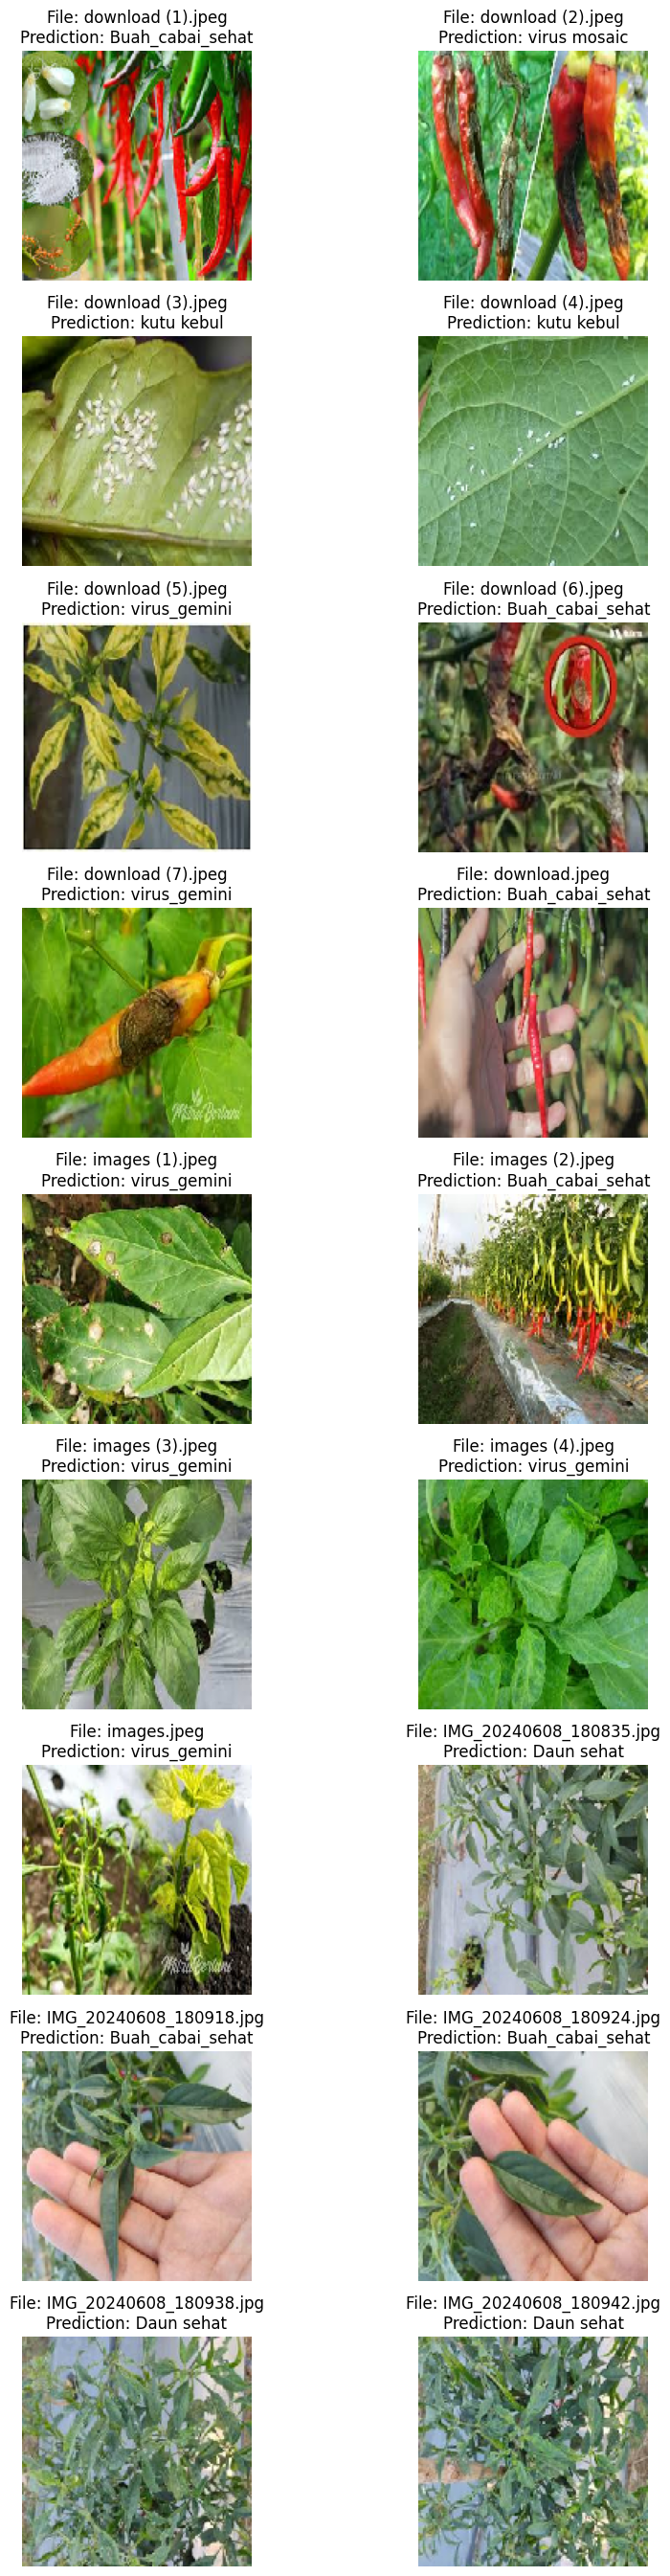

In [28]:
# Fungsi untuk memprediksi gambar dan menampilkannya dalam grid
def predict_and_show_images_in_folder(folder_path, model, class_labels):
    try:
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpeg', '.png', '.jpg'))]
        num_images = len(image_files)
        num_columns = 2
        num_rows = num_images // num_columns + (num_images % num_columns != 0)
        
        plt.figure(figsize=(10, num_rows * 3))
        
        for i, filename in enumerate(image_files):
            image_path = os.path.join(folder_path, filename)
            img = load_img(image_path, target_size=(img_width, img_height))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0

            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]
            result = class_labels[predicted_class]

            plt.subplot(num_rows, num_columns, i + 1)
            plt.imshow(img)
            plt.title(f'File: {filename}\nPrediction: {result}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

# pemanggilan folder input & model
folder_path = 'D:\Seluruh File Skripsi Arya\Tes'  
model_path = 'D:\Seluruh File Skripsi Arya\plant_disease_cnn.h5'  
img_width, img_height = 150, 150

# Daftar label kelas 
class_labels = ['Buah_cabai_sehat', 'Buah Sakit', 'Daun sehat', 'kutu kebul',
                'virus_gemini', 'virus keriting', 'virus mosaic']  

# Memuat model
model = load_model(model_path)

# Memanggil fungsi predict_and_show_images_in_folder
predict_and_show_images_in_folder(folder_path, model, class_labels)

In [11]:
# Menampilkan grafik akurasi dan loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(7, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

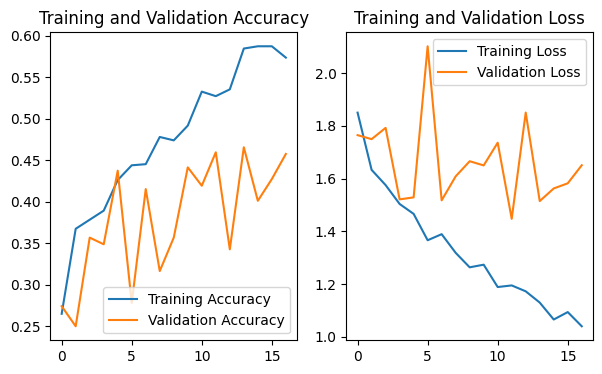

In [12]:
# Plot training history
plot_training_history(history)

In [13]:
# Evaluasi model pada data validasi dan hitung metrik
# def evaluate_model_on_validation(model, validation_generator):
#     validation_generator.reset()
#     Y_pred = model.predict(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
#     y_pred = np.where(Y_pred > 0.5, 1, 0)  # Binarize predictions
#     y_true = validation_generator.classes  # True labels

#     print('Confusion Matrix')
#     print(confusion_matrix(y_true, y_pred))

#     print('Classification Report')
#     target_names = ['Healthy', 'Diseased']
#     print(classification_report(y_true, y_pred, target_names=target_names))

# Evaluasi model dan tampilkan metrik
# evaluate_model_on_validation(model, validation_generator)

In [14]:
def evaluate_model_on_validation(model, validation_generator):
    # Reset generator
    validation_generator.reset()
    
    # Mendapatkan prediksi dari model
    Y_pred = model.predict(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
    
    # Mendapatkan indeks dengan probabilitas tertinggi untuk setiap prediksi
    y_pred = np.argmax(Y_pred, axis=1)
    
    # Mendapatkan label asli
    y_true = validation_generator.classes

    # Confusion Matrix
    print('Confusion Matrix')
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Classification Report
    print('Classification Report')
    target_names = list(validation_generator.class_indices.keys())  # Mendapatkan nama kelas dari generator
    print(classification_report(y_true, y_pred, target_names=target_names))

# Evaluasi model dan tampilkan metrik
evaluate_model_on_validation(model, validation_generator)

32/32 [==============================] - 15s 461ms/step
Confusion Matrix
[[34  0 20  5 23 25  1]
 [ 6  0  0  1  2  5  1]
 [33  0 16  4 14 17  4]
 [12  0  8  0 11 16  1]
 [19  0 13  3 12 17  6]
 [43  0 15  5 26 43  6]
 [ 8  0  2  2  3 13  2]]
Classification Report
                         precision    recall  f1-score   support

Resize Buah_cabai_sehat       0.22      0.31      0.26       108
      resize_Buah Sakit       0.00      0.00      0.00        15
      resize_Daun sehat       0.22      0.18      0.20        88
      resize_kutu kebul       0.00      0.00      0.00        48
    resize_virus gemini       0.13      0.17      0.15        70
  resize_virus keriting       0.32      0.31      0.31       138
    resize_virus mosaic       0.10      0.07      0.08        30

               accuracy                           0.22       497
              macro avg       0.14      0.15      0.14       497
           weighted avg       0.20      0.22      0.20       497



C:\Program Files\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
